In [1]:
## importing all required libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import ELU,Activation
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, binary_crossentropy

In [7]:
### Reading all data, train test and validation set

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
val_test = pd.read_csv("Dig-MNIST.csv")

In [10]:
print(train.shape)
print(test.shape)
print(val_test.shape)

(60000, 785)
(5000, 785)
(10240, 785)


In [11]:
img_r,img_c = 28,28
classes = 10

#### ONE HOT ENCODING:

One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector.

In [12]:
def data_prep(raw):
    out_y = tensorflow.keras.utils.to_categorical(raw.label,classes)

    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_r, img_c, 1)
    # normalization
    out_x = x_shaped_array / 255
    return out_x, out_y

In [13]:
x_train, y_train = data_prep(train)
x_val,y_val = data_prep(val_test)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((x_train, x_val)),np.concatenate((y_train, y_val)),
                                                   test_size=0.1,shuffle=True)

In [16]:
print(f"Training data size is {x_train.shape}")
print(f"Training data size is {y_train.shape}")
print(f"Testing data size is {x_test.shape}")
print(f"Training data size is {y_test.shape}")

Training data size is (63216, 28, 28, 1)
Training data size is (63216, 10)
Testing data size is (7024, 28, 28, 1)
Training data size is (7024, 10)


In [17]:
### different ways to visulaize the data

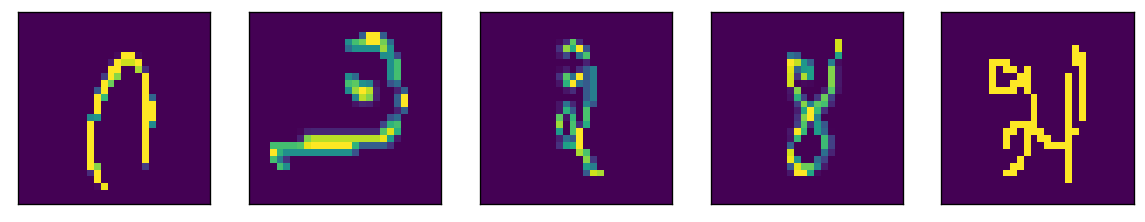

In [18]:
def get_image(row, dataset):
    row_values = dataset.iloc[row].values
    image_matrix = row_values.reshape(img_r, img_c)
    return image_matrix

fig, ax = plt.subplots(1, 5, figsize=(12, 9), dpi=120)
plt.setp(ax, xticks=[], yticks=[])

ax_n=0
for i in range(1,6,1):
    ax[ax_n].imshow(get_image(i, train.drop('label',axis=1)))
    ax_n+=1

In [19]:
title=[]
for i in range(1, 10):
    for j in range(0,10):
        if y_train[i][j] == 1:
            title.append(j)
title

[5, 5, 4, 0, 0, 1, 8, 0, 5]

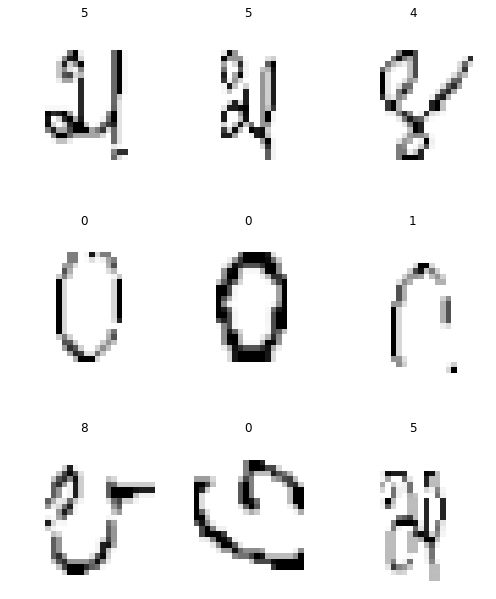

In [20]:
plt.figure(figsize=(7,9))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('Greys'))
    plt.title(title[i-1])
    plt.axis('off')
plt.tight_layout()

### Activation Function

In [21]:
leakyrelu = tensorflow.keras.layers.LeakyReLU(alpha=0.01)

#relu = tensorflow.keras.layers.relu(alpha=0.01)

### Model 


tf.keras.layers.Conv2D( filters, kernel_size, strides=(1, 1), padding='valid/same', data_format=None,dilation_rate=(1, 1),groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None,**kwargs
)

In [23]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, padding='same',input_shape=(img_r, img_c, 1)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=3, padding = 'same'))
model.add(BatchNormalization(scale=False, center=True))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3), padding = 'same'))
model.add(BatchNormalization(scale=False,center=True))
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(BatchNormalization(scale=False,center=True))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization(scale=False,center=True))
model.add(Activation('relu'))
model.add(Dense(classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 64)       192       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 64)       192       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 28, 28, 64)       

In [31]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='/Users/neethug/Desktop/Neethu/DataScience Projects/KanadaDigitsMNSIT/model.png', show_shapes=True)
# from IPython.display import Image
# Image("/Users/neethug/Desktop/Neethu/DataScience Projects/KanadaDigitsMNSIT/model.png")

#### DATA Augumentation for avoiding over fitting.

One way to avoid overfitting and improve the accuracy is to increase the variability of existing samples. Which is also helps to compensate lack of data. Data augmentation generates data from existing samples by applying various transformations to the original dataset. This method aims to increase the number of unique input samples, which, in turn, will allow the model to show better accuracy on the validation dataset.


https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator


In [32]:
from keras.preprocessing.image import ImageDataGenerator

In [33]:
# use data augmentation to improve accuracy and prevent overfitting
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.2, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=False,  
        vertical_flip=False) 

train_generator = augs_gen.flow(x_train, y_train, batch_size=128)
valid_generator = augs_gen.flow(x_val, y_val, batch_size=128)

## Early stoping

It stops the building of the modelling if the monitored metric is not optimizing anymore.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [34]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=6, mode='auto', restore_best_weights=True)

## Learning Rate Reduction


Reduces a learning rate when a metric is stopped being optimized.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

In [37]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0001 ,patience=6, verbose=1,  factor=0.6)

In [38]:
epochs = 25
BATCH = 128

In [39]:
model.compile(optimizer = 'adam',loss = binary_crossentropy,metrics=['accuracy'])
model_fit = model.fit(train_generator, epochs=epochs,batch_size =BATCH ,validation_data= valid_generator, verbose =1,callbacks=[early_stop,lr_reduction])

Epoch 1/25
494/494 [==============================] - 275s 556ms/step - loss: 0.0601 - accuracy: 0.9240 - val_loss: 0.6753 - val_accuracy: 0.1361 - lr: 0.0010
Epoch 2/25
494/494 [==============================] - 302s 611ms/step - loss: 0.0199 - accuracy: 0.9721 - val_loss: 0.0691 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 3/25
494/494 [==============================] - 314s 635ms/step - loss: 0.0150 - accuracy: 0.9789 - val_loss: 0.0400 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 4/25
494/494 [==============================] - 306s 620ms/step - loss: 0.0130 - accuracy: 0.9811 - val_loss: 0.0357 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 5/25
494/494 [==============================] - 319s 646ms/step - loss: 0.0119 - accuracy: 0.9823 - val_loss: 0.0327 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 6/25
494/494 [==============================] - 459s 929ms/step - loss: 0.0108 - accuracy: 0.9835 - val_loss: 0.0490 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 7/25
494/494 [==========================

In [ ]:
# !mkdir -p saved_model
# model.save('saved_model/my_model')

In [ ]:
# load_model = tensorflow.keras.models.load_model('saved_model/my_model')
# load_model.summary()

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 64)       192       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 64)       192       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 28, 28, 64)       

### plotting

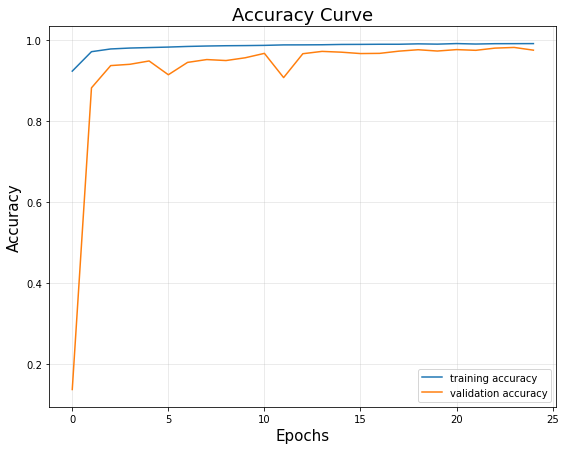

In [42]:
# Defining Figure
f = plt.figure(figsize=(20,7))

#For Accuracy - subplot
f.add_subplot(121)

plt.plot(model_fit.epoch,model_fit.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_accuracy'],label = "validation accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


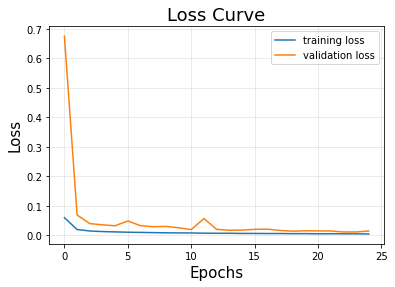

In [43]:
#Adding Subplot (For Loss)
f.add_subplot(122)

plt.plot(model_fit.epoch,model_fit.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_loss'],label="validation loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Evaluation

In [45]:
evaluate_test = model.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy =", "{:.7f}%".format(evaluate_test[1]*100))
print("Loss     =" ,"{:.9f}".format(evaluate_test[0]))

220/220 [==============================] - 9s 38ms/step - loss: 0.0051 - accuracy: 0.9923

Accuracy = 99.2312074%
Loss     = 0.005108574


In [46]:
y_predict = model.predict(x_test)

In [47]:
y_predict_max = np.argmax(y_predict,axis=1) 
y_predict_max

array([4, 3, 8, ..., 7, 3, 2])

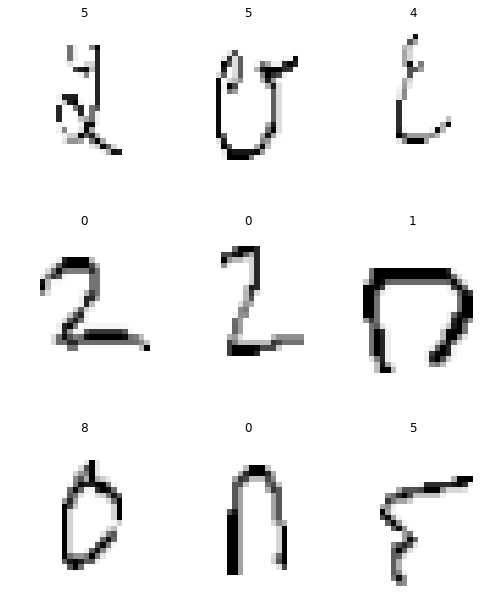

In [49]:
plt.figure(figsize=(7,9))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.imshow(x_test[i], cmap=plt.get_cmap('Greys'))
    plt.title(title[i-1])
    plt.axis('off')
plt.tight_layout()

In [50]:
## test data

In [53]:
def data_prep(raw):
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_r, img_c, 1)
    
    return x_shaped_array

test_x = data_prep(test)
test_x.shape

(5000, 28, 28, 1)

In [54]:
test_generator = augs_gen.flow(test_x)

In [55]:
y_hat = model.predict_generator(test_generator)

/var/folders/k3/6qdc5wpd2hxb3jxhzssny0_c0000gn/T/ipykernel_51551/4031129170.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_hat = model.predict_generator(test_generator)


In [57]:
submission_label = np.argmax(y_hat, axis=1)
submission_label = pd.Series(submission_label, name="label")

image_id = pd.Series(range(0,len(test)))
image_id = pd.Series(image_id, name="id")

In [58]:
submission = pd.concat([image_id,submission_label],axis = 1)
submission.to_csv("submission.csv", index=False)
pd.read_csv("submission.csv").head()

,id,label
0,0,1
1,1,5
2,2,5
3,3,5
4,4,4


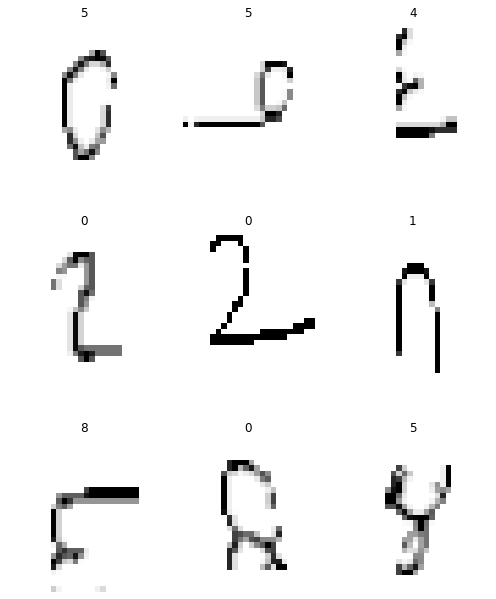

In [69]:
plt.figure(figsize=(7,9))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.imshow(test_x[i], cmap=plt.get_cmap('Greys'))
    plt.title(title[i-1])
    plt.axis('off')
plt.tight_layout()